Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 243s 6s/step - accuracy: 0.8978 - loss: 3.1020 - val_accuracy: 0.8738 - val_loss: 11.4019
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 198s 6s/step - accuracy: 0.9805 - loss: 0.4113 - val_accuracy: 0.9779 - val_loss: 0.1871
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 158s 4s/step - accuracy: 0.9863 - loss: 0.0720 - val_accuracy: 0.9890 - val_loss: 0.0303
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 166s 5s/step - accuracy: 0.9892 - loss: 0.0317 - val_accuracy: 0.9924 - val_loss: 0.0244
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 269s 8s/step - accuracy: 0.9895 - loss: 0.0307 - val_accuracy: 0.9924 - val_loss: 0.0201
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 181s 5s/step - accuracy: 0.9887 - loss: 0.0332 - val_accuracy: 0.9922 - val_loss: 0.0224
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 172s 5s/step - accuracy: 0.9888 - loss: 0.0330 - val_accuracy: 0.9925 - val_loss: 0.0218
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 210s 6s/step - accuracy: 0.9905 - loss: 0.0249 - val_accuracy: 0.9926 - 

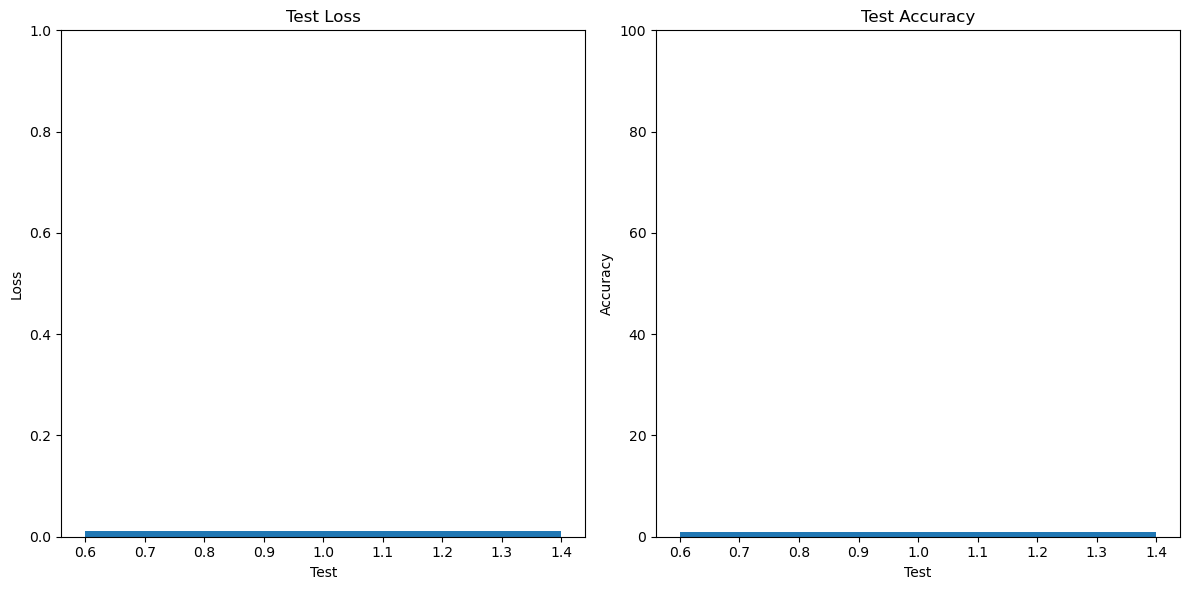

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


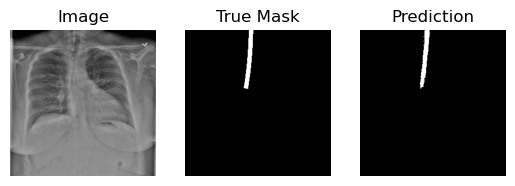

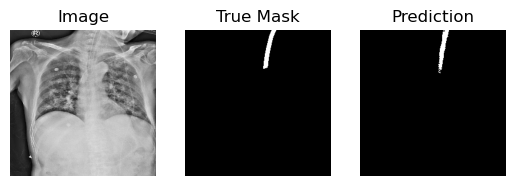

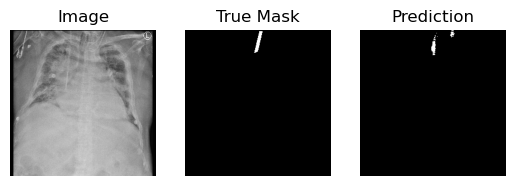

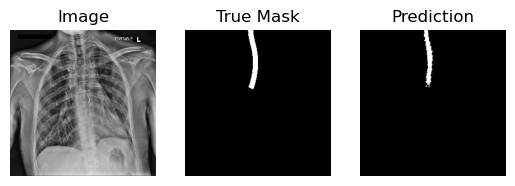

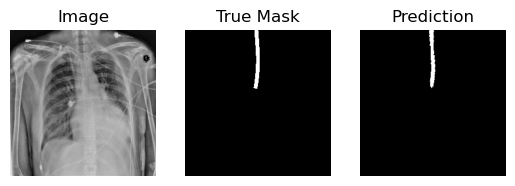

Test Loss: 0.011667056940495968
Test Accuracy: 99.55253601074219%


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Add
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.metrics import MeanIoU
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
# path
train_path = 'D:/test2/ETT_v3/Fold5/train/'
train_annot_path = 'D:/test2/ETT_v3/Fold5/trainannot/'
val_path = 'D:/test2/ETT_v3/Fold5/val/'
val_annot_path = 'D:/test2/ETT_v3/Fold5/valannot/'
test_path = 'D:/test2/ETT_v3/Fold5/test/'
test_annot_path = 'D:/test2/ETT_v3/Fold5/testannot/'
def fcn_8s(input_shape=(256, 256, 3), num_classes=2):
    # 載入VGG16模型，不包括全連接層
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # 取得特定的VGG層作為跳躍連結
    block4_pool = base_model.get_layer('block4_pool').output
    block3_pool = base_model.get_layer('block3_pool').output

    # 最後一層卷積層的輸出
    x = base_model.output
    
    # 擴張卷積層
    x = Conv2D(4096, (7, 7), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(4096, (1, 1), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # 第一個轉置卷積層
    x = Conv2DTranspose(512, (4, 4), strides=(2, 2), padding='same')(x)
    x = Add()([x, block4_pool])

    # 第二個轉置卷積層
    x = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same')(x)
    x = Add()([x, block3_pool])

    # 最後一個轉置卷積層，恢復到原始圖像尺寸
    x = Conv2DTranspose(num_classes, (16, 16), strides=(8, 8), padding='same')(x)

    # 輸出層，使用softmax進行多類別分類
    output = Activation('softmax')(x)

    # 建立模型
    model = Model(inputs=base_model.input, outputs=output)
    
    return model

def process_image_and_mask(img_path, label_path, size=(256, 256)):
    # 加載指定尺寸的圖像及其對應標籤
    image = load_img(img_path, target_size=size)
    mask = load_img(label_path, target_size=size, color_mode='grayscale')
    
    # 轉換為數組並進行正規化
    image = img_to_array(image) / 255.0
    mask = (img_to_array(mask) > 128).astype(np.float32)  # 進行二值化閾值處理並轉換為浮點數型態
    
    return image, mask


def setup_data_pipeline(image_dir, mask_dir, batch_size):
    # 列出給定目錄中的所有文件
    img_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))
    
    img_paths = [os.path.join(image_dir, file) for file in img_files]
    mask_paths = [os.path.join(mask_dir, file) for file in mask_files]
    
    # 準備圖像和標籤
    images, masks = [], []
    for img_path, mask_path in zip(img_paths, mask_paths):
        img, mask = process_image_and_mask(img_path, mask_path)
        images.append(img)
        masks.append(mask)
    
    # 將列表轉換為Numpy數組
    images = np.array(images)
    masks = np.array(masks)
    
    # 創建 TensorFlow 數據集
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(len(images)).batch(batch_size)
    return dataset


# 準備訓練和驗證數據集
train_dataset = setup_data_pipeline(train_path, train_annot_path, batch_size=8)
val_dataset = setup_data_pipeline(val_path, val_annot_path, batch_size=8)
test_dataset = setup_data_pipeline(test_path, test_annot_path, batch_size=8)
model = fcn_8s()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,          # 在5个轮次后停止，如果验证集损失没有改善
    verbose=1,           # 打印消息
    restore_best_weights=True  # 恢复训练过程中最好的模型权重
)



# 設定訓練的epochs數
epochs = 30

# 訓練資料
history = model.fit(
    train_dataset, 
    epochs=epochs, 
    validation_data=val_dataset,
    callbacks=[early_stopping]  # 将EarlyStopping加入到训练过程中
)

# 測試資料
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")
# Visualize some predictions
def plot_predictions(images, masks, predictions):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title("Image")
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title("True Mask")
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i], cmap='gray')
        plt.title("Prediction")
        plt.axis('off')
        plt.show()
def calculate_iou(y_true, y_pred, num_classes):
    # y_pred 需要透過 argmax 獲取最有可能的類別
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, tf.int32)
    y_true = tf.cast(y_true, tf.int32)
    iou_calculator = MeanIoU(num_classes=num_classes)
    iou_calculator.update_state(y_true, y_pred)
    return iou_calculator.result().numpy()
def indicator_within_range(y_true, y_pred, threshold, P):
    # 计算阈值，并确保为整数类型，与 y_true 和 y_pred 保持一致
    threshold_pixels = tf.cast(P * threshold, tf.int32)  # 将阈值转换为整数
    return tf.cast(tf.abs(y_true - y_pred) <= threshold_pixels, tf.float32)

def accuracy_within_0_5_cm(y_true, y_pred, P):
    # 確保 y_true 和 y_pred 都是 tf.int32 類型
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.int32)
    
    K = tf.size(y_true, out_type=tf.int32)  # tf.size 的 out_type 也設定為 tf.int32
    indicator_values = indicator_within_range(y_true, y_pred, 0.5, P)
    return tf.reduce_sum(indicator_values) / tf.cast(K, tf.float32) * 100

def accuracy_within_1_cm(y_true, y_pred, P):
    # 確保 y_true 和 y_pred 都是 tf.int32 類型
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.int32)
    
    K = tf.size(y_true, out_type=tf.int32)  # tf.size 的 out_type 也設定為 tf.int32
    indicator_values = indicator_within_range(y_true, y_pred, 1.0, P)
    return tf.reduce_sum(indicator_values) / tf.cast(K, tf.float32) * 100
def check_predictions(y_true, y_pred, num_classes):
    if tf.reduce_any(y_pred >= num_classes) or tf.reduce_any(y_pred < 0):
        raise ValueError(f"`y_pred` has invalid values. All elements must be in range [0, {num_classes-1}]")
    if tf.reduce_any(y_true >= num_classes) or tf.reduce_any(y_true < 0):
        raise ValueError(f"`y_true` has invalid values. All elements must be in range [0, {num_classes-1}]")
# 修改evaluate_model函數以包含精確度計算
def evaluate_model(model, dataset, num_classes, P):
    total_iou = 0
    accuracy_0_5_cm_total = 0
    accuracy_1_0_cm_total = 0
    count = 0
    for images, masks in dataset:
        predictions = model.predict(images)
        y_pred = tf.argmax(predictions, axis=-1)
        y_true = tf.cast(tf.squeeze(masks), tf.int32)


        if not tf.reduce_all(tf.less(y_true, num_classes)):
            print("y_true contains values outside [0, num_classes-1]")
        if not tf.reduce_all(tf.less(y_pred, num_classes)):
            print("y_pred contains values outside [0, num_classes-1]")

        # 檢查預測值是否有效
        check_predictions(y_true, y_pred, num_classes)
        
        iou_calculator = MeanIoU(num_classes=num_classes)
        iou_calculator.update_state(y_true, y_pred)
        iou_score = iou_calculator.result().numpy()
        total_iou += iou_score
        
        # 計算精度
        accuracy_0_5_cm_total += accuracy_within_0_5_cm(y_true, y_pred, P)
        accuracy_1_0_cm_total += accuracy_within_1_cm(y_true, y_pred, P)
        
        count += 1

    avg_iou = total_iou / count if count else 0
    avg_accuracy_0_5_cm = accuracy_0_5_cm_total / count if count else 0
    avg_accuracy_1_0_cm = accuracy_1_0_cm_total / count if count else 0
    
    return avg_iou, avg_accuracy_0_5_cm, avg_accuracy_1_0_cm

# 設定像素到公分的轉換比例
P = 72  # 每公分72像素

# 在訓練資料集上評估模型
train_iou, train_accuracy_0_5_cm, train_accuracy_1_0_cm = evaluate_model(model, train_dataset, num_classes=2, P=P)
print(f"Training Data: Average IOU: {train_iou}")
print(f"Training Data: Average Accuracy within 0.5 cm: {train_accuracy_0_5_cm}")
print(f"Training Data: Average Accuracy within 1.0 cm: {train_accuracy_1_0_cm}")
def plot_test_results(test_loss, test_accuracy):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # 在图表中显示测试损失
    ax[0].bar(1, test_loss)
    ax[0].set_title('Test Loss')
    ax[0].set_xlabel('Test')
    ax[0].set_ylabel('Loss')
    ax[0].set_ylim([0, max(test_loss * 1.1, 1)])  # 确保图表显示合理的范围

    # 在图表中显示测试精度
    ax[1].bar(1, test_accuracy)
    ax[1].set_title('Test Accuracy')
    ax[1].set_xlabel('Test')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_ylim([0, 100])  # 假设精度是以百分比显示

    plt.tight_layout()
    plt.show()

# 调用函数以绘制测试损失和精度
plot_test_results(test_loss, test_accuracy)
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# 调用该函数以绘制历史记录
plot_training_history(history)
for images, masks in train_dataset.take(1):
    predictions = model.predict(images)
    predictions = tf.argmax(predictions, axis=-1)
    predictions = predictions[..., tf.newaxis]
    plot_predictions(images.numpy(), masks.numpy(), predictions.numpy()) 
def display_test_results(test_loss, test_accuracy):
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy * 100}%")

    # 如果您想用图形展示这些结果，可以这样做：
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # 绘制测试损失
    ax[0].bar(['Test Loss'], [test_loss])
    ax[0].set_title('Test Loss')
    ax[0].set_ylim([0, max(test_loss * 1.2, 1)])  # 设置y轴范围略高于损失值

    # 绘制测试精度
    ax[1].bar(['Test Accuracy'], [test_accuracy])
    ax[1].set_title('Test Accuracy')
    ax[1].set_ylim([0, 1])  # 精度范围通常在0到1之间

    plt.tight_layout()
    plt.show()


display_test_results(test_loss, test_accuracy)